# Wikipedia pages
The following is a quick exploration of the provided dataset on the probability of a user clicking a given link within a Wikipedia source article to a target article, rather than another link to the same target article at some other place in the source article.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

In [2]:
data = pd.DataFrame.from_csv('data_n2.tsv', sep='\t')
data = data.drop('probability_ordered', axis=1) # we ignore col 'probability_ordered

In [3]:
data.head(5)

,target_article_id,target_article_name,probability,target_position_in_text,target_position_in_section,target_in_table,target_position_in_text_normed,target_position_in_section_normed,source_article_max_section_number,source_article_max_number_of_links
source_article_id,,,,,,,,,,
27275061,1946322,Katipo,0.705357,8,8,0.0,0.195122,0.727273,6,41
27275061,1946322,Latrodectus katipo,0.294643,29,14,0.0,0.707317,0.608696,6,41
18328851,16562095,Sino Land Company Limited,0.575000,14,14,0.0,0.736842,0.875000,3,19
18328851,20477410,Sino Hotels (Holdings) Limited,0.545455,15,15,0.0,0.789474,0.937500,3,19
18328851,16562095,Sino Land,0.425000,18,2,0.0,0.947368,0.666667,3,19


In [4]:
samples, feats = data.shape
print("num of samples: {}, num of features: {}".format(samples, feats-1))

num of samples: 205278, num of features: 9


# Features

Let's have a look at the features

,features,correlation
0,target_article_id,6.564554e-17
2,target_position_in_text,-1.002721e-01
3,target_position_in_section,-4.167372e-02
4,target_in_table,-1.321881e-01
5,target_position_in_text_normed,-1.948319e-01
6,target_position_in_section_normed,5.278587e-02
7,source_article_max_section_number,6.054259e-17
8,source_article_max_number_of_links,1.843562e-17


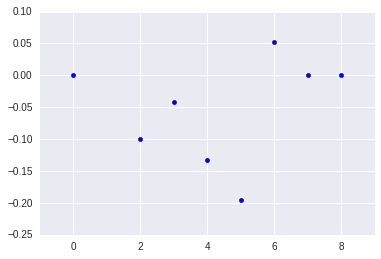

In [6]:
corr_matrix = data.corr(method='pearson') # correlation matrix between all cols

corr_target = corr_matrix.probability.to_frame().reset_index()
corr_target.columns = ['features', 'correlation']
# drop the row for the correlation of probability with itself
corr_target = corr_target[corr_target.features != 'probability'] 
plt.scatter(corr_target.index, corr_target.correlation)
corr_target

So with the text feature dropped, we only have 8 features left, and out of those 3 show a 0 correlation value with the target. 

Of these three, the `target_article_id` makes sense, since it will be different for each target link, and point to at least two different probability values. The different IDs have no ordered relation between themselves.

On the other hand, the virtually zero correlation values for `source_article_max_section_number` and `source_article_max_number_of_links` is surprising. By themselves, these features tell us nothing about the target data.

The most informative feature is `target_position_in_text_normed` at close to $-0.20$ correlation. This seems reasonable, as one might assume users tend to click on earlier links rather than later ones.

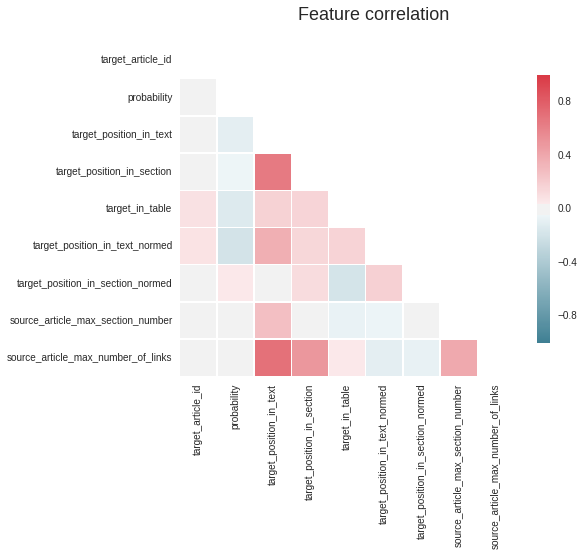

In [51]:
def correlation_matrix(corr, title):
    """Plot the pairwise correlations in corr matrix""" 
    sns.set_style("whitegrid")
    # Generate a mask for the upper triangle 
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
 
    # Set up the matplotlib figure 
    f, ax = plt.subplots(figsize=(8, 6))
 
    # Generate a custom diverging colormap 
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
 
    # Ddata the heatmap with the mask and correct aspect ratio 
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, square=True,
                linewidths=.5, cbar_kws={"shrink": .8}, ax=ax)
 
    # Set title 
    f.suptitle(title, fontsize=18)
    sns.set_style('darkgrid')
    
correlation_matrix(corr_matrix, "Feature correlation")

On top of the findings on correlation to the target value, the features are mostly very weakly correlated amongst themselves, as we can see with the correlation matrix above. Notable exceptions are `target_position_in_text` with `target_position_in_section` and `target_position_in_text` and `source_article_max_number_of_links`.

Now, in order to better understand the feature's relations to the target value, let's look at each one's relation to the target value more closely.

## Feature `target_position_in_text`

Below is a jointplot (scatterplot and histograms) for `probability` vs `target_position_in_text`. 

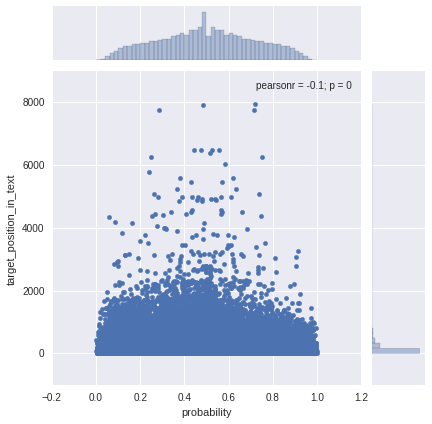

In [66]:
sns.jointplot(x='probability', y='target_position_in_text', data=data)

Since the values of the `target_position_in_text` feature values lie mainly in the interval $[0,2000]$, let's do the same, but getting rid of all data points above the 90th percentile, and this time using a kernel density estimation and contour plot.

/home/alexis/Applications/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


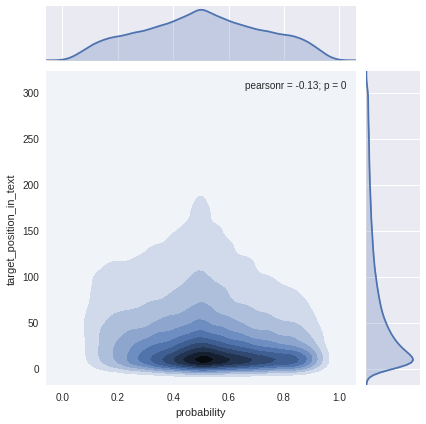

In [96]:
data_filt = data[data.target_position_in_text < data.target_position_in_text.quantile(.9)]
sns.jointplot(x='probability', y='target_position_in_text', data=data_filt, kind='kde');

## Feature `target_position_in_section`

Similarly for feature `target_position_in_section`

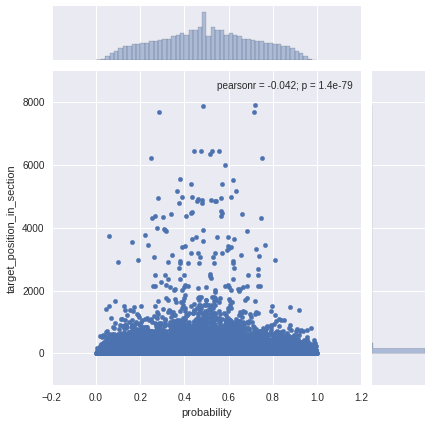

In [88]:
sns.jointplot(x='probability', y='target_position_in_section', data=data)

Similarly to above, most of the values of the `target_position_in_section` feature seem to lie in the $[0,1000]$ range, so we'll again do the same for the 90th percentile.

/home/alexis/Applications/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


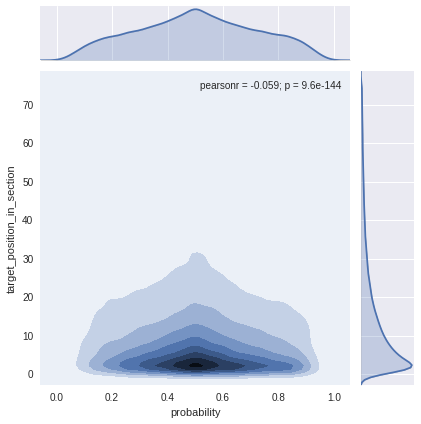

In [104]:
data_filt = data[data.target_position_in_section < data.target_position_in_section.quantile(.9)]
sns.jointplot(x='probability', y='target_position_in_section', data=data_filt, kind='kde');

## Feature `target_position_in_text_normed`

Similarly for feature `target_position_in_text_normed`

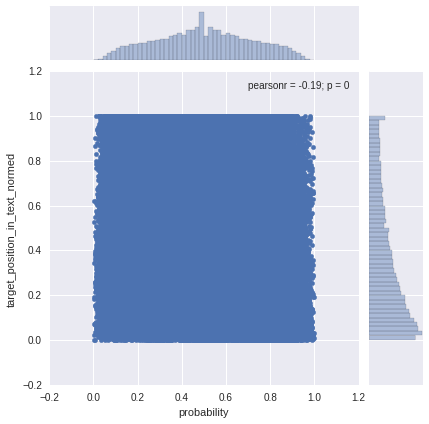

In [105]:
sns.jointplot(x='probability', y='target_position_in_text_normed', data=data)

In this case, the scatter plot doesn't tell us much, since the data points are densely distributed over the whole are of the plot. Let's look at the contour plot for the whole set in this case.

/home/alexis/Applications/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


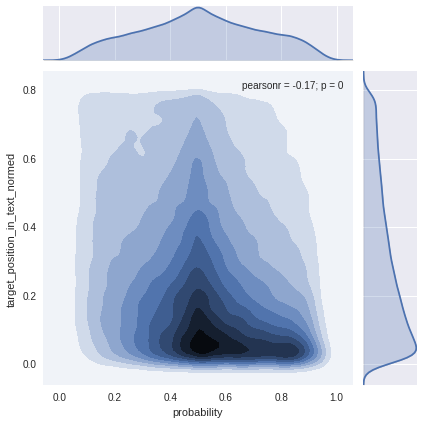

In [123]:
data_filt = data[data.target_position_in_text_normed < data.target_position_in_text_normed.quantile(.9)]
sns.jointplot(x='probability', y='target_position_in_text_normed', data=data_filt, kind='kde');

## Feature `target_position_in_section_normed`
Similarly for feature `target_position_in_section_normed`


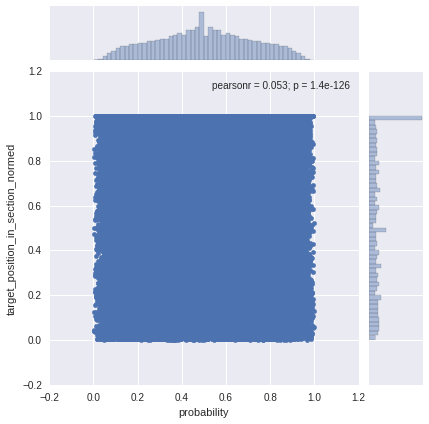

In [107]:
sns.jointplot(x='probability', y='target_position_in_section_normed', data=data)

Again, the scatter plot doesn't tell us much, but the histogram indicates that there's many of the target links are the last ones appearing in their section. The distribution is almost constant for the rest of the values.  

We can have a look at the contour plot again to get more insight.

/home/alexis/Applications/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


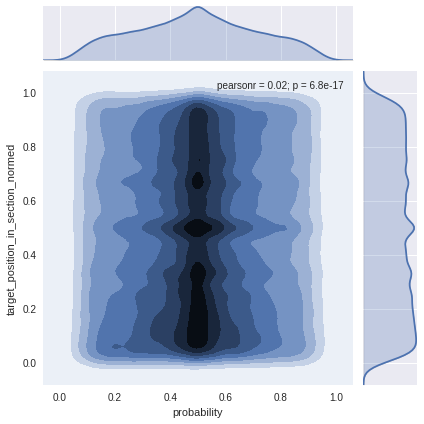

In [124]:
data_filt = data[data.target_position_in_section_normed < data.target_position_in_section_normed.quantile(.9)]
sns.jointplot(x='probability', y='target_position_in_section_normed', data=data_filt, kind='kde');

## Feature `source_article_max_section_number`

Similarly for feature `source_article_max_section_number`


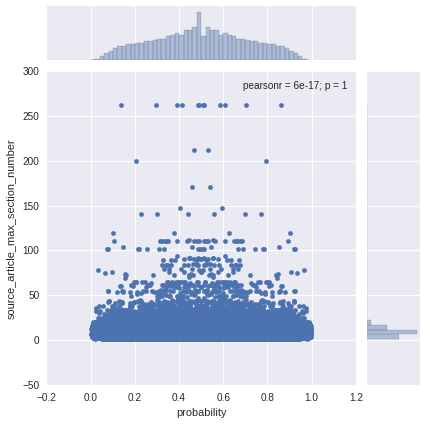

In [109]:
sns.jointplot(x='probability', y='source_article_max_section_number', data=data)

The histogram shows that there are very few values with more than 15 sections in their article. In fact

In [128]:
quant=.9
print(quant*100, "% of the data points have less than", 
      data.source_article_max_section_number.quantile(.90), "sections")

90.0 % of the data points have less than 14.0 sections


Since there are so few numbers of sections for most of the data, we can see it almost as a categorical feature. So let's look at the boxplots for the data points within the 90th percentile.

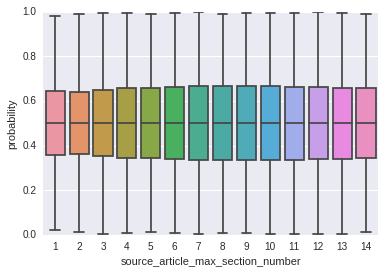

In [134]:
sns.boxplot(x="source_article_max_section_number", y="probability", 
            data=data[data.source_article_max_section_number <= data.source_article_max_section_number.quantile(quant)]);

From this we can see that there is no great variation amongst these different values. All the medians seem to be almost exactly at 0.5, and there is some slight variation between the first and third quartiles of the different categories.

## Feature `source_article_max_number_of_links`

Similarly for feature `source_article_max_number_of_links`


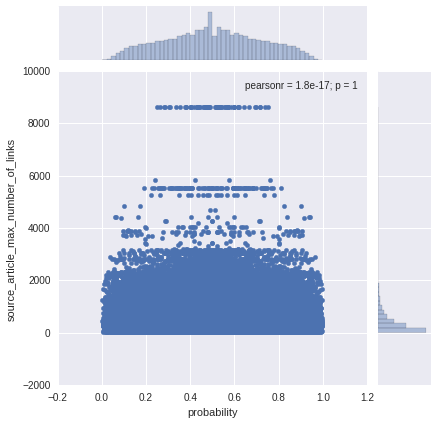

In [111]:
sns.jointplot(x='probability', y='source_article_max_number_of_links', data=data)

Let's again look at the contour plot for the 90th percentile.

/home/alexis/Applications/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


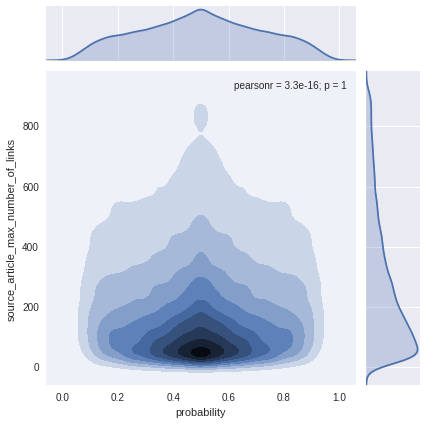

In [112]:
data_filt = data[data.source_article_max_number_of_links < data.source_article_max_number_of_links.quantile(.9)]
sns.jointplot(x='probability', y='source_article_max_number_of_links', data=data_filt, kind='kde');

## Feature `target_in_table`

This feature requires a slightly different approach for visualisation, since it is categorical (or actually boolean). 

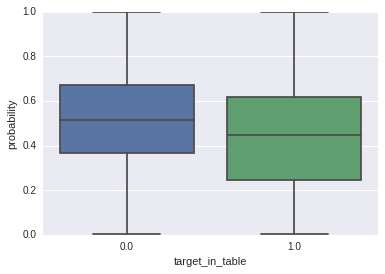

In [102]:
sns.boxplot(x="target_in_table", y="probability", data=data);

Both categories have a median around 0.5, but as we can see, the box for category $1$ is slightly below the other, for each quartile.

This difference becomes more visible when looking at a violinplot of the two (combines the boxplot with a kernel density estimation). It's hard to draw meaningful insight into the data itself from this though.

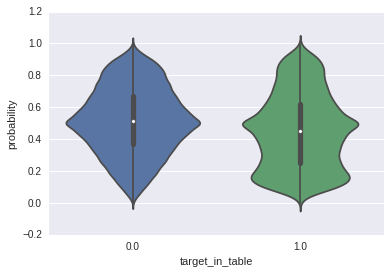

In [135]:
sns.violinplot(x="target_in_table", y="probability", data=data);

Overall, this evaluation of the features tells us that there is little predictive value in them. They have mostly very week correlations to the output data and very similar distributions amongst themselves, which is far from ideal, when trying to train a model to solve such a problem.

# Let's regress

In [70]:
from sklearn.dummy import DummyRegressor
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import SGDRegressor, Ridge
from sklearn.preprocessing import scale, PolynomialFeatures
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor


We need to split the data, first to sepearate the features and target, and then into training and testing sets.

In [114]:
X = data.drop(['probability','target_article_name'], axis=1)
y = data.probability.values

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Baseline regressor
To start out, let's see how well a baseline regressor performs. We'll do this with a dummy regressor that always guesses a probability of 0.5.

In [8]:
dummy = DummyRegressor(strategy='constant', constant=0.5)
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)
mean_absolute_error(y_test, y_pred)


0.177474285837668

Now let's see how this performs against some other simple regressor models.

## SGD regressor
Start out with a simple stochastic gradient descent. 

We will need to preprocess the features so the SGD regressor can perform reasonably. 

In [49]:
reg = SGDRegressor(loss='huber', n_iter=50)
reg.fit(scale(X_train), y_train)
y_pred = reg.predict(scale(X_test))
mean_absolute_error(y_test, y_pred)

0.17317896816993494

## Ridge regression

In [110]:
reg = Ridge()
reg.fit(scale(X_train), y_train)
y_pred = reg.predict(scale(X_test))
mean_absolute_error(y_test, y_pred)

0.17318386590218093

This is better than the baseline regressor. 

Since we have such a limited feature set to begin with, with relatively weak predictive information, one can assume models will perform better if we generate more features based on these. Let's try generating some more for the model, and see how ridge regression then performs.

/home/alexis/Applications/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


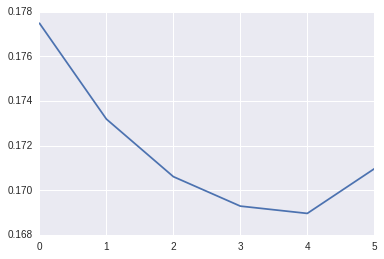

In [120]:
reg = Ridge()
mae = []
for i in range(0,6):
    poly_X = PolynomialFeatures(i).fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(poly_X, y, random_state=0)
    reg.fit(scale(X_train), y_train)
    y_pred = reg.predict(scale(X_test))
    mae.append(mean_absolute_error(y_test, y_pred))

plt.plot(mae)

As we can see, there might be some issues with too large data, so to be thorough, we should be pre-scaling the data in some way in this case. However, the result here is noticeably better than with just the standard feature set.

In [121]:
print(mae[4])

0.168958327578


Let's see if this gets better results for SGD as well.

/home/alexis/Applications/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


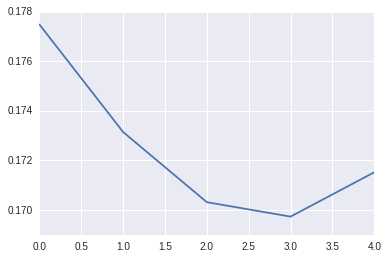

In [117]:
reg = SGDRegressor(loss='huber', n_iter=50)
mae = []
for i in range(0,5):
    poly_X = PolynomialFeatures(i).fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(poly_X, y, random_state=0)
    reg.fit(scale(X_train), y_train)
    y_pred = reg.predict(scale(X_test))
    mae.append(mean_absolute_error(y_test, y_pred))

plt.plot(mae)

In [118]:
mae[3]

0.16973326576747783

So ridge regression and SGD perform best with polynomial features up to degree 3 and 4.

These models can quite probably be improved more by tuning their hyperparameters. For the purpose of this exercise, we will focus more on the following model though. 

**Note** that for none of the above was there any cross-validation performed, so these are just 'ball-park' figures. But they give a pretty stable notion of what the cost of these models would be.

## Multi-layer perceptron regression
Let's try a neural network model to predict our probability values, since by definition, it will allow us to generate additional features for the model as well (width of layers).



In [94]:
reg = MLPRegressor()
reg.fit(scale(X_train), y_train)
y_pred = reg.predict(scale(X_test))
mean_absolute_error(y_test, y_pred)

0.16991014353870548

Without any parameter tuning, using only the default settings, the MLP regressor performs better than all the other models, and does so very rapidly. Let's see how this can be pushed further.

Using `GridSearchCV`, sklearn can find the best parameters (from a provided set). With limited time and computational resources, we are only able to test a few of these. To keep it simple, we will test only for the same number of units in each level (i.e. 100), and only a few different number of levels (1 to 5). On top of this, we test different activation functions, and different values for `alpha`. 

In [105]:
gs = GridSearchCV(reg, param_grid={
        'hidden_layer_sizes': [(100), (100,100),  (100, 100, 100), (100, 100, 100, 100), (100, 100, 100, 100, 100)],
        'activation': ['logistic', 'tanh', 'relu'],
        'alpha': [0.001, 0.0005, 0.0001, 0.00005]}, cv=5, n_jobs=8)

gs.fit(scale(X_train), y_train)
y_pred = gs.predict(scale(X_test))
mean_absolute_error(y_test, y_pred)

0.16647868938055868

The results yielded by the grid search use the parameters below. This is achieved with a 5-fold cross validation. 

In [106]:
gs.best_params_

{'activation': 'relu',
 'alpha': 0.0005,
 'hidden_layer_sizes': (100, 100, 100, 100, 100)}

If we compare this result to the baseline regressor above, we can indeed see that this model performs noticeably better than a constant predictor.

## Observations
- Most of the work above is quite superficial. There is no in-depth reflection on how to better train the model with regard to the given data, or effort to gain insight into the data itself.
- In our models above, we are essentially predicting the same value twice, given that each probability has its 'compliment' in the sister-link. The assumption made for this was that since we have data available for both links, the model will gain better performance by training on both. So it can be looked at as if we had double the initial feature-set size. It might be interesting to look whether this can be combined and seen as a single data-point for each instance, and whether it increases the efficiency of the prediction. 
- Most of regression models fit data to minimise least squares error, or some other cost function. In none of the models above is the default to minimise mean absolute error, so the measure we get from the trained models could probably be optimised if the models' cost functions were set to *mae* instead. 